In this exercise we are going to use Boston Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/Boston.csv"
BostonData = pd.read_csv(url)
del BostonData['Unnamed: 0']
BostonData.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### let's first categorize medv to 4 groups. 
Lowest 20% medv is categorized as Level 1

next 30% medv is categorized as Level 2

next 30% medv is categorized as Level 3

Top 20% medv is categorized as Level 4


In [3]:
BostonData['medvCategory'] = '1'
mask_cat2 = ((BostonData['medv'] > BostonData['medv'].quantile(.2)) & 
            (BostonData['medv'] <= BostonData['medv'].quantile(.5)))   
mask_cat3 = ((BostonData['medv'] > BostonData['medv'].quantile(.5)) & 
            (BostonData['medv'] <= BostonData['medv'].quantile(.8)))  
mask_cat4 = (BostonData['medv'] > BostonData['medv'].quantile(.8)) 

BostonData.loc[mask_cat2,'medvCategory'] = '2'
BostonData.loc[mask_cat3,'medvCategory'] = '3'
BostonData.loc[mask_cat4,'medvCategory'] = '4'

#### Our goal is to predict medvCategory based on 'rm', 'ptratio' and 'lstat'

#### First standardize your input (X) variables - put standardized values in new variables 'rm_st' , 'ptratio_st' and 'lstat_st'

In [4]:
def standardize(z):
    min_z = z.min()
    max_z = z.max()
    return (z-min_z)/(max_z-min_z)

In [5]:
BostonData['rm_st'] = standardize(BostonData['rm'])
BostonData['ptratio_st'] = standardize(BostonData['ptratio'])
BostonData['lstat_st'] = standardize(BostonData['lstat'])
BostonData.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,medvCategory,rm_st,ptratio_st,lstat_st
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,3,0.577505,0.287234,0.089680
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,3,0.547998,0.553191,0.204470
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,4,0.694386,0.553191,0.063466
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,4,0.658555,0.648936,0.033389
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,4,0.687105,0.648936,0.099338


#### Run a KNN classifier with 5 nearest neighbors and report your misclassification error; set weights to uniform

In [6]:
X = BostonData[['rm_st','ptratio_st','lstat_st']]
y = BostonData['medvCategory']

In [7]:
from sklearn import neighbors, metrics
knn = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
print knn.predict(X[1:5])
print y[1:5].values

['3' '4' '4' '4']
['3' '4' '4' '4']


In [9]:
knn.score(X,y)

0.7865612648221344

In [10]:
BostonData['medvCategory'].value_counts()

2    154
3    149
1    102
4    101
Name: medvCategory, dtype: int64

Is this error reliable?

Answer: No because we have only considered training information thus far and not used validation/cross-validation

#### Now use 10-fold cross-validation to choose the most efficient K (number of neighbors)

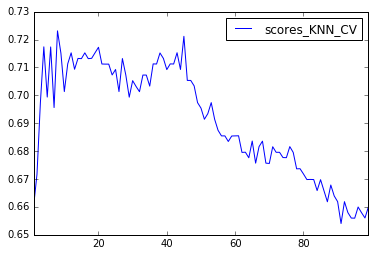

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cross_validation

kf = cross_validation.KFold(len(BostonData), n_folds=10, shuffle=True)
scores_KNN_CV = []
k_range = np.arange(1,100)
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
    scores = []
    for train_index, test_index in kf:
        knn.fit(X.iloc[train_index],y[train_index])
        predict_rate = knn.score(X.iloc[test_index],y.iloc[test_index])
        scores.append(predict_rate)
    scores_KNN_CV.append(np.mean(scores))

scores_KNN_CV_df = pd.DataFrame({'scores_KNN_CV': scores_KNN_CV}, index = k_range)
scores_KNN_CV_df.plot()

 Explain your findings: The optimal k appears to be around 20 as it maximizes the performance of the function

#### Train your algorithm with the optimal K you found above (don't worry if it changes from time to time - if that is the case use the one that is usually the best). After training your model with that K, Use it to predict the class of a neighborhood with rm =2, lstat = 3.5 and ptratio of 19. 

In [12]:
# We shall standardize our input first!
def standardized_val(z,v): #First input is column from df, second is value to be standardized
    min_z = z.min()
    max_z = z.max()
    return (v-min_z)/(max_z-min_z)

In [13]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 20, weights = 'uniform')
knn.fit(X,y)
knn.predict([[standardized_val(BostonData['rm'],2),standardized_val(BostonData['ptratio'],19),standardized_val(BostonData['lstat'],3.5)]])

array(['2'], dtype=object)

# Now let's run a KNN-regression model to predict MEDV of the same point

In [19]:
X = BostonData[['rm_st','ptratio_st','lstat_st']]
y = BostonData['medv']

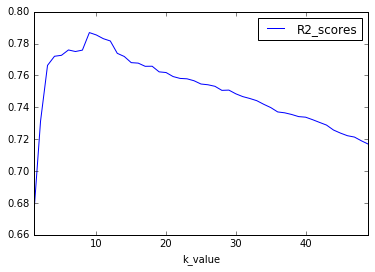

In [21]:
# Need to determine k value again since goal is to predict medv and not just the category
kf = cross_validation.KFold(len(BostonData),n_folds = 10, shuffle = True)
R2_scores_KNN = []
k_range = np.arange(1,50)
for k in k_range:
    knn = neighbors.KNeighborsRegressor(n_neighbors = k, weights='uniform')
    scores = []
    for train_index, test_index in kf:
        knn.fit(X.iloc[train_index],y.iloc[train_index])
        error_val = knn.score(X.iloc[test_index],y.iloc[test_index])
        scores.append(error_val)
    R2_scores_KNN.append(np.mean(scores))
    
Score_KNN_CV_df = pd.DataFrame({'R2_scores':R2_scores_KNN,'k_value':k_range})
Score_KNN_CV_df.plot(x='k_value',y='R2_scores')

The best value of k appears to be 10

In [27]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 10, weights='uniform')
knn.fit(X,y)
knn.predict([[standardized_val(BostonData['rm'],2),standardized_val(BostonData['ptratio'],19),standardized_val(BostonData['lstat'],3.5)]])

array([ 22.65])